<a href="https://colab.research.google.com/github/GGpark1/User-Log-data-analytics/blob/main/e_commerce_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Module import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#pd.options.display.float_format = "{:,.2f}".format
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import warnings
warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv('/content/drive/MyDrive/CP2/2019-Oct.csv')

In [3]:
#df['event_time'] = pd.to_datetime(df['event_time']).dt.tz_convert('Asia/Tehran')

df['event_time'] = pd.to_datetime(df['event_time']).dt.tz_convert(None)

In [4]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


## Basic Preprocessing

In [5]:
# 시간 정보 삭제
# 요일 별 방문자 파악

daily_summary_table=df.groupby(by=[df['event_time'].dt.normalize()]).agg(
    Number_of_daily_visits=('user_session', lambda x: x.nunique()),
    Number_of_daily_visitors=('user_id', lambda x: x.nunique()))

## EDA

In [6]:
# 일자 별 방문 수
# 일자 별 방문자 수

daily_summary_table.head()

,Number_of_daily_visits,Number_of_daily_visitors
event_time,,
2019-10-01,268737,190188
2019-10-02,261252,184965
2019-10-03,241086,170668
2019-10-04,300651,209410
2019-10-05,276914,194958


In [7]:
# 일자 별 판매량
# 일자 별 판매액

sales = df.loc[df['event_type'] == 'purchase'].groupby(by=[df['event_time'].dt.normalize()]).agg(
    Number_of_daily_sales=('event_type', 'count'),
    Total_daily_sales=('price', 'sum')).reset_index()

sales.head()


,event_time,Number_of_daily_sales,Total_daily_sales
0,2019-10-01,19307,6275964.01
1,2019-10-02,19469,6213628.53
2,2019-10-03,19255,6233782.98
3,2019-10-04,27041,8623684.47
4,2019-10-05,23494,7341596.91


In [8]:
carts = df.loc[df['event_type'] == 'cart'].groupby(by=[df['event_time'].dt.normalize()]).agg(
    Number_of_daily_carts=('event_type', 'count')).reset_index()

carts.head()

,event_time,Number_of_daily_carts
0,2019-10-01,16658
1,2019-10-02,17268
2,2019-10-03,19323
3,2019-10-04,43829
4,2019-10-05,35497


In [9]:
daily_summary_table=pd.merge(left=daily_summary_table,
                          right=sales,
                          left_on=['event_time'],
                          right_on=['event_time'],
                          how='left')

In [10]:
daily_summary_table=pd.merge(left=daily_summary_table,
                          right=carts,
                          left_on=['event_time'],
                          right_on=['event_time'],
                          how='left')

In [11]:
daily_summary_table.head()

,event_time,Number_of_daily_visits,Number_of_daily_visitors,Number_of_daily_sales,Total_daily_sales,Number_of_daily_carts
0,2019-10-01,268737,190188,19307,6275964.01,16658
1,2019-10-02,261252,184965,19469,6213628.53,17268
2,2019-10-03,241086,170668,19255,6233782.98,19323
3,2019-10-04,300651,209410,27041,8623684.47,43829
4,2019-10-05,276914,194958,23494,7341596.91,35497


In [12]:
# 피쳐 순서 조정

daily_summary_table = daily_summary_table[['event_time', 'Number_of_daily_visits', 'Number_of_daily_visitors', 'Number_of_daily_carts', 'Number_of_daily_sales', 'Total_daily_sales']]

In [13]:
# 전환율 테이블 구성

conversion_table = pd.DataFrame({'event_time' : daily_summary_table['event_time']})

conversion_table['Visit-Cart-conversion'] = daily_summary_table['Number_of_daily_carts'] / daily_summary_table['Number_of_daily_visits']
conversion_table['Visit-Sale-conversion'] = daily_summary_table['Number_of_daily_sales'] / daily_summary_table['Number_of_daily_visits']
conversion_table['Cart-Sale-conversion'] = daily_summary_table['Number_of_daily_sales'] / daily_summary_table['Number_of_daily_carts']

In [14]:
conversion_table.head()

,event_time,Visit-Cart-conversion,Visit-Sale-conversion,Cart-Sale-conversion
0,2019-10-01,0.061986,0.071843,1.159023
1,2019-10-02,0.066097,0.074522,1.127461
2,2019-10-03,0.080150,0.079868,0.996481
3,2019-10-04,0.145780,0.089941,0.616966
4,2019-10-05,0.128188,0.084842,0.661859


### 방문 세션
- 일자별 방문 세션
  - 8~25일의 방문 세션이 평균보다 높음
- 요일별 방문 세션
  - 금요일에 방문 세션이 평균적으로 가장 많음
  - 목요일에 방문 세션이 평균적으로 가장 적음
- 고유 방문자 수와 방문 세션의 패턴이 일치함

In [15]:
print('Daily Visits Statistics')
print('-'*50)
print(daily_summary_table['Number_of_daily_visits'].describe())
print('-'*50)
print('Visit Statistics by Dates')
print(daily_summary_table.groupby(by=daily_summary_table['event_time'].dt.day_name()).Number_of_daily_visits.describe())

Daily Visits Statistics
--------------------------------------------------
count        31.000000
mean     299510.548387
std       25531.553700
min      241086.000000
25%      278957.500000
50%      301219.000000
75%      319668.500000
max      339943.000000
Name: Number_of_daily_visits, dtype: float64
--------------------------------------------------
Visit Statistics by Dates
            count       mean           std       min        25%       50%  \
event_time                                                                  
Friday        4.0  321772.50  16017.261304  300651.0  313704.00  325731.0   
Monday        4.0  293353.00  26033.151442  263437.0  276610.00  294346.5   
Saturday      4.0  298041.75  19140.215435  276914.0  286412.75  296976.5   
Sunday        4.0  309080.00  32756.353552  273034.0  285634.75  311671.5   
Thursday      5.0  282820.60  24557.356776  241086.0  281446.00  293587.0   
Tuesday       5.0  301032.40  27672.766817  268737.0  276723.00  308348.0   
Wed

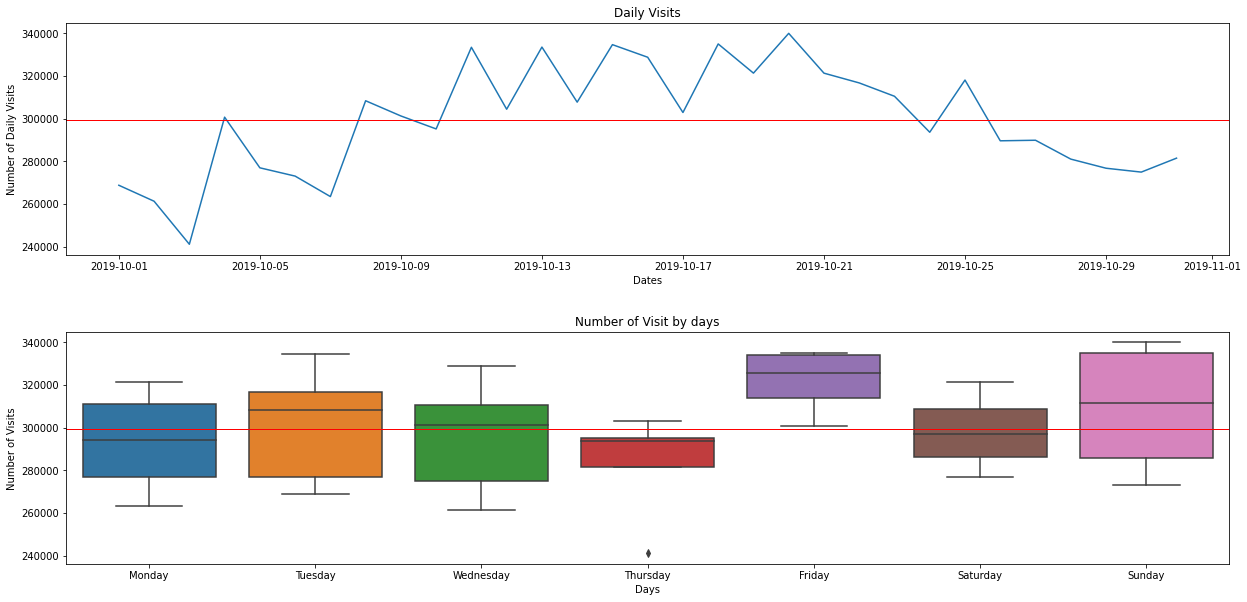

In [16]:
# 일자별 방문 세션

fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
sns.lineplot(x='event_time',
              y='Number_of_daily_visits',
              data=daily_summary_table,
             ax=ax1)
plt.axhline(y=299510, color='r', linewidth=1)
plt.title('Daily Visits')
plt.ylabel('Number of Daily Visits')
plt.xlabel('Dates')

# 요일별 방문 세션

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=daily_summary_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=daily_summary_table['Number_of_daily_visits'],
            ax=ax2)
plt.axhline(y=299510, color='r', linewidth=1)
plt.title('Number of Visit by days')
plt.ylabel('Number of Visits')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

### 판매량
- 일자별 판매량
  - 2~3일 판매량이 높음 : 해당 요일에 어떤 물건이 많이 팔리는지 확인 필요
  - 10일~19일 판매량 높음 : 해당 요일에 어떤 물건이 많이 팔리는지 확인 필요
- 요일별 판매량
  - 금, 일의 판매량이 높음
  - 화, 목의 판매량이 낮음
  - 요일별로 어떤 물건이 많이 팔리는지 확인 필요

In [17]:
print('Daily Sales Statistics')
print('-'*50)
print(daily_summary_table['Number_of_daily_sales'].describe())
print('-'*50)
print('Sales Statistics by Dates')
print(daily_summary_table.groupby(by=daily_summary_table['event_time'].dt.day_name()).Number_of_daily_sales.describe())

Daily Sales Statistics
--------------------------------------------------
count       31.000000
mean     23962.870968
std       3083.275701
min      19255.000000
25%      21685.500000
50%      23929.000000
75%      25617.500000
max      31394.000000
Name: Number_of_daily_sales, dtype: float64
--------------------------------------------------
Sales Statistics by Dates
            count      mean          std      min       25%      50%  \
event_time                                                             
Friday        4.0  25761.00  1318.700623  23929.0  25369.75  26037.0   
Monday        4.0  24015.50  3463.157567  21112.0  21311.50  23272.5   
Saturday      4.0  24044.25  1208.220558  22653.0  23283.75  24075.5   
Sunday        4.0  25058.25  3232.769852  22171.0  23095.00  24250.5   
Thursday      5.0  22732.80  3618.598513  19255.0  20099.00  21993.0   
Tuesday       5.0  22902.00  3063.898579  19307.0  20374.00  23072.0   
Wednesday     5.0  23831.80  4671.538687  19469.0  20

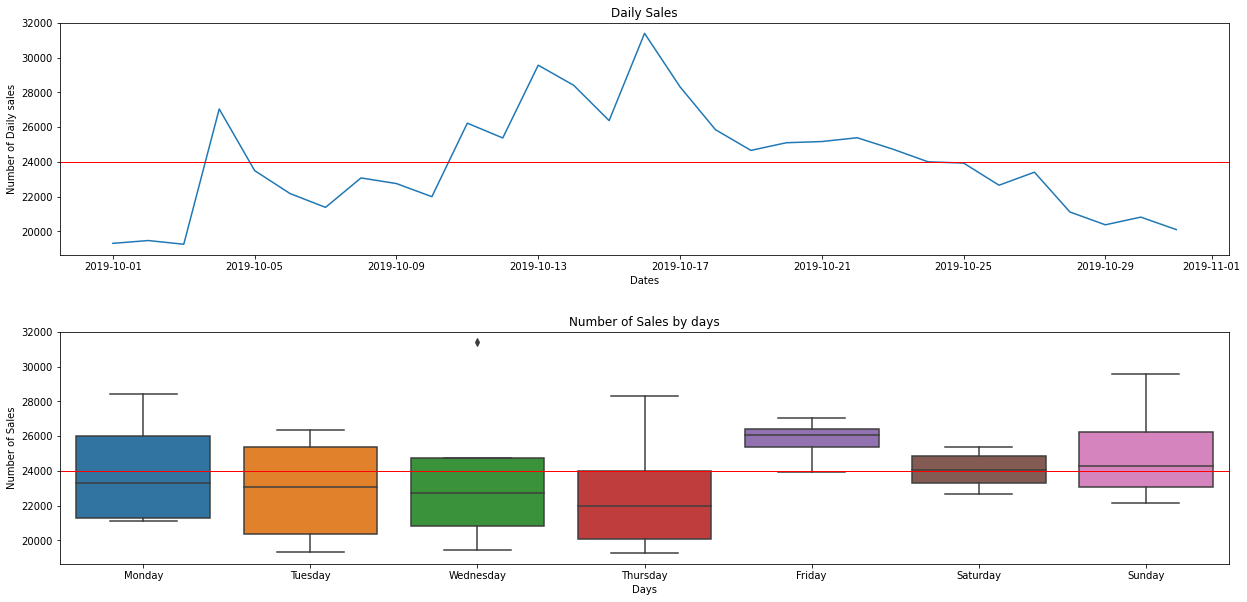

In [18]:
# 일자별 판매량

fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
sns.lineplot(x='event_time',
              y='Number_of_daily_sales',
              data=daily_summary_table,
             ax=ax1)
plt.axhline(y=23962, color='r', linewidth=1)
plt.title('Daily Sales')
plt.ylabel('Number of Daily sales')
plt.xlabel('Dates')

# 요일별 판매량

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=daily_summary_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=daily_summary_table['Number_of_daily_sales'],
            ax=ax2)
plt.axhline(y=23962, color='r', linewidth=1)
plt.title('Number of Sales by days')
plt.ylabel('Number of Sales')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

In [19]:
conversion_table.head()

,event_time,Visit-Cart-conversion,Visit-Sale-conversion,Cart-Sale-conversion
0,2019-10-01,0.061986,0.071843,1.159023
1,2019-10-02,0.066097,0.074522,1.127461
2,2019-10-03,0.080150,0.079868,0.996481
3,2019-10-04,0.145780,0.089941,0.616966
4,2019-10-05,0.128188,0.084842,0.661859


### Visit-Cart Conversion
- 방문 세션과 패턴이 대체로 일치함
- 주말의 Visit-Cart Conversion이 평일보다 평균적으로 높음
- Visit-Cart Conversion은 요일보다 물건에 더 영향을 받을 수 있을 것 같음
- **Event_time을 Product로 대체하여 분석 진행 필요(물건 별 Visit-Cart Conversion)**

In [20]:
# Visit-Cart Conversion
# Visit-Cart Conversion은 요일보다 물건에 더 영향을 받을 것 같다. 
# event_time을 product로 대체해서 분석 진행

print('Conversion Rates Statistics')
print('-'*50)
print(conversion_table['Visit-Cart-conversion'].describe())
print('-'*50)
print('Visit-Cart-conversion Rates Statistics by Dates')
print('-'*50)
print(conversion_table.groupby(by=conversion_table['event_time'].dt.day_name())['Visit-Cart-conversion'].describe())

Conversion Rates Statistics
--------------------------------------------------
count    31.000000
mean      0.098687
std       0.031993
min       0.059685
25%       0.064351
50%       0.115750
75%       0.120885
max       0.148060
Name: Visit-Cart-conversion, dtype: float64
--------------------------------------------------
Visit-Cart-conversion Rates Statistics by Dates
--------------------------------------------------
            count      mean       std       min       25%       50%       75%  \
event_time                                                                      
Friday        4.0  0.111427  0.034094  0.064336  0.102897  0.117796  0.126326   
Monday        4.0  0.097986  0.039179  0.063480  0.067264  0.091338  0.122061   
Saturday      4.0  0.109772  0.028064  0.067979  0.107063  0.121460  0.124169   
Sunday        4.0  0.107406  0.021973  0.074460  0.106917  0.117964  0.118453   
Thursday      5.0  0.091842  0.033679  0.059685  0.064366  0.080150  0.121678   
Tuesday 

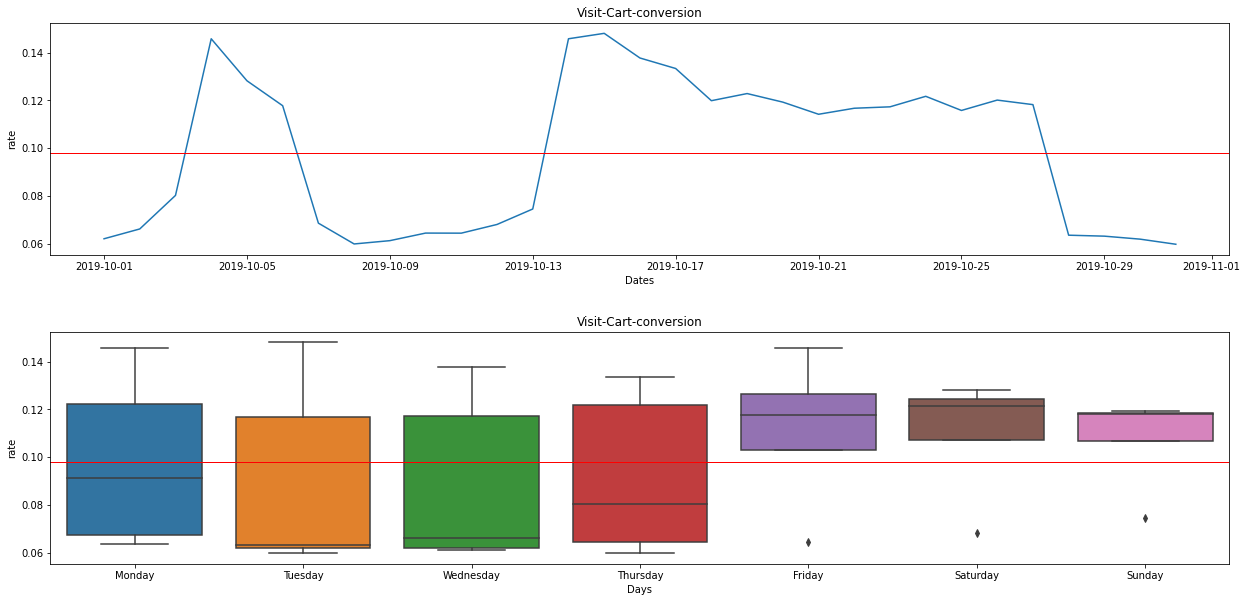

In [21]:
# 일자별 Visit-Cart Conversion

fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
sns.lineplot(x='event_time',
              y='Visit-Cart-conversion',
              data=conversion_table,
             ax=ax1)
plt.axhline(y=0.098, color='r', linewidth=1)
plt.title('Visit-Cart-conversion')
plt.ylabel('rate')
plt.xlabel('Dates')

# 요일별 Visit-Cart Conversion

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=conversion_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=conversion_table['Visit-Cart-conversion'],
            ax=ax2)
plt.axhline(y=0.098, color='r', linewidth=1)
plt.title('Visit-Cart-conversion')
plt.ylabel('rate')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

## Cart-Sale Conversion
- 방문 세션과 판매량이 가장 많은 요일임에도 금토일의 전환율이 눈에 띄게 낮음
- 반대로, 카트에 물건을 담은 횟수 대비 구매 수는 월~목이 제일 많음
- 주말은 충동 구매할 확률이 높다?

In [22]:
# Cart-Sale Conversion

print('Cart-Sale Conversion Rates Statistics')
print('-'*50)
print(conversion_table['Cart-Sale-conversion'].describe())
print('-'*50)
print('Cart-Sale Conversion Rates Statistics by Dates')
print('-'*50)
print(conversion_table.groupby(by=conversion_table['event_time'].dt.day_name())['Cart-Sale-conversion'].describe())

Cart-Sale Conversion Rates Statistics
--------------------------------------------------
count    31.000000
mean      0.891834
std       0.270879
min       0.532252
25%       0.656628
50%       0.693346
75%       1.183893
max       1.251057
Name: Cart-Sale-conversion, dtype: float64
--------------------------------------------------
Cart-Sale Conversion Rates Statistics by Dates
--------------------------------------------------
            count      mean       std       min       25%       50%       75%  \
event_time                                                                      
Friday        4.0  0.783360  0.293154  0.616966  0.637190  0.646956  0.793126   
Monday        4.0  0.921806  0.303405  0.633220  0.672968  0.934879  1.183717   
Saturday      4.0  0.791080  0.290554  0.624781  0.644743  0.656628  0.802965   
Sunday        4.0  0.795613  0.265102  0.619184  0.667181  0.686438  0.814871   
Thursday      5.0  0.944766  0.247571  0.671808  0.701323  0.996481  1.157709   


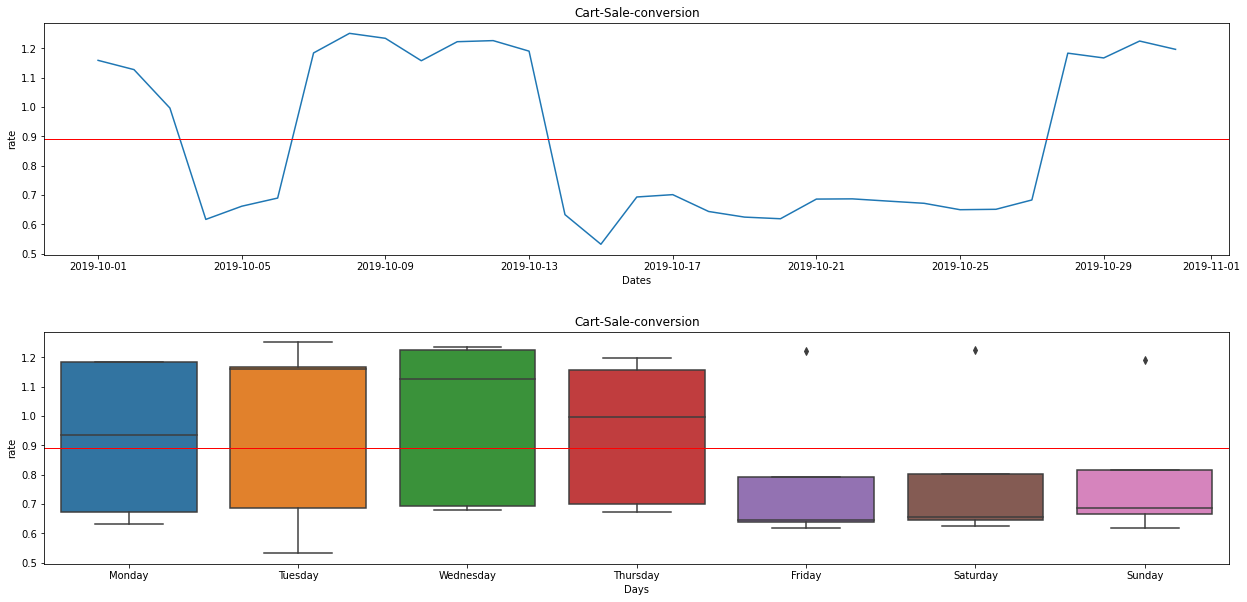

In [23]:
# Cart-Sales-Conversion
# 금-토-일은 카트에 담지 않고 바로 구매하나?
# 판매량은 금-토-일이 제일 많음
# 카트에 물건을 담은 횟수 대비 구매 수는 월~목이 제일 많음
# 카트에 물건을 담은 사람들은 주말 충동 구매를 하지 않음?

fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
sns.lineplot(x='event_time',
              y='Cart-Sale-conversion',
              data=conversion_table,
             ax=ax1)
plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Cart-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Dates')

# 요일별 판매량

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=conversion_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=conversion_table['Cart-Sale-conversion'],
            ax=ax2)
plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Cart-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

In [24]:
"""

# 요일 별로 극단치를 제거할 수 있을까?

conversion_threshold = np.percentile(conversion_table['Cart-Sale-conversion'], [1, 95])
conversion_threshold_filter = np.logical_and(conversion_table['Cart-Sale-conversion'] >= conversion_threshold[0],
                                             conversion_table['Cart-Sale-conversion'] <= conversion_threshold[1])

Cart_Sale_conversion_filtered = conversion_table.loc[conversion_threshold_filter]

fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
sns.lineplot(x='event_time',
              y='Cart-Sale-conversion',
              data=Cart_Sale_conversion_filtered,
             ax=ax1)
#plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Cart-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Dates')

# 요일별 판매량

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=Cart_Sale_conversion_filtered['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=Cart_Sale_conversion_filtered['Cart-Sale-conversion'],
            ax=ax2)
#plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Cart-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

"""

"\n\n# 요일 별로 극단치를 제거할 수 있을까?\n\nconversion_threshold = np.percentile(conversion_table['Cart-Sale-conversion'], [1, 95])\nconversion_threshold_filter = np.logical_and(conversion_table['Cart-Sale-conversion'] >= conversion_threshold[0],\n                                             conversion_table['Cart-Sale-conversion'] <= conversion_threshold[1])\n\nCart_Sale_conversion_filtered = conversion_table.loc[conversion_threshold_filter]\n\nfig=plt.figure(figsize=(18,9))\nax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프\nsns.lineplot(x='event_time',\n              y='Cart-Sale-conversion',\n              data=Cart_Sale_conversion_filtered,\n             ax=ax1)\n#plt.axhline(y=0.89, color='r', linewidth=1)\nplt.title('Cart-Sale-conversion')\nplt.ylabel('rate')\nplt.xlabel('Dates')\n\n# 요일별 판매량\n\nax2=fig.add_subplot(2,1,2)\n\nsns.boxplot(x=Cart_Sale_conversion_filtered['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 \n            y=Cart_Sale_conversion_filtered['Cart-Sale-conv

## Visit-Sale Conversion
- 월, 토, 일이 방문-구매 conversion이 비교적 높음
- 금요일은 방문수를 생각했을 때 구매율이 다소 저조한 편임
- 방문율 1위는 금요일이지만, Conversion은 평일과 비슷함
- 물건을 판매할 수 있는 기회를 놓치고 있다?
- 4\~5일과 13\~17일 경의 전환율이 다른 날보다 높음 : 해당 요일에 주로 구매하는 상품은 무엇일까?

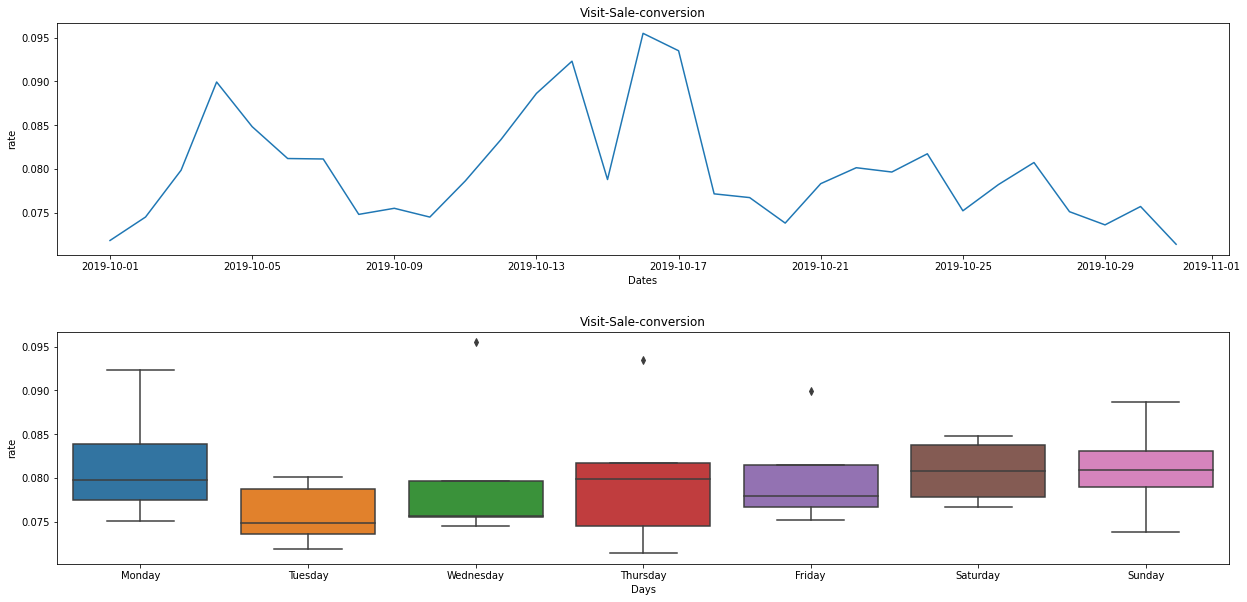

In [25]:
# 통상적인 임금일 전후로 Conversion이 높음
# 월, 토, 일이 방문-구매 conversion이 비교적 높음 
# 금요일은 방문수를 생각했을 때 구매율이 다소 저조한 편임(방문율 1위는 금 but Conversion은 평일과 비슷함)
# 물건을 판매할 수 있는 기회를 놓치고 있다?

fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
sns.lineplot(x='event_time',
              y='Visit-Sale-conversion',
              data=conversion_table,
             ax=ax1)
#plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Visit-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Dates')

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=conversion_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=conversion_table['Visit-Sale-conversion'],
            ax=ax2)
#plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Visit-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

In [26]:
conversion_table['event_time'] = conversion_table['event_time'].dt.dayofweek

In [27]:
# 금요일 이상치 제거

conversion_table_filtered = conversion_table.drop(3)
conversion_table_filtered

,event_time,Visit-Cart-conversion,Visit-Sale-conversion,Cart-Sale-conversion
0,1,0.061986,0.071843,1.159023
1,2,0.066097,0.074522,1.127461
2,3,0.080150,0.079868,0.996481
4,5,0.128188,0.084842,0.661859
5,6,0.117736,0.081202,0.689697
6,0,0.068525,0.081150,1.184246
7,1,0.059809,0.074825,1.251057
8,2,0.061191,0.075520,1.234158
9,3,0.064366,0.074517,1.157709
10,4,0.064336,0.078655,1.222564


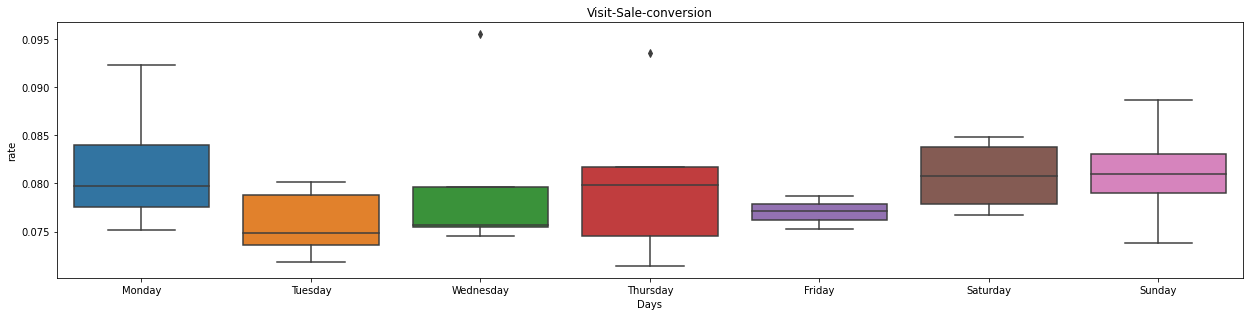

In [28]:
fig=plt.figure(figsize=(18,9))
ax2=fig.add_subplot(2,1,1)
sns.boxplot(x=conversion_table_filtered['event_time'], # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=conversion_table_filtered['Visit-Sale-conversion'],
            ax=ax2)
#plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Visit-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

## EDA - 제품별

In [2]:
df = pd.read_csv('/content/drive/MyDrive/CP2/2019-Oct.csv')

In [3]:
df['event_time'] = pd.to_datetime(df['event_time']).dt.tz_convert(None)

In [4]:
df["categori_code_level_1"] = df["category_code"].str.split(".", expand=True)[0]
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,categori_code_level_1
0,2019-10-01 00:00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,NaN
1,2019-10-01 00:00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,appliances
2,2019-10-01 00:00:01,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,furniture
3,2019-10-01 00:00:01,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,computers
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics


In [7]:
df.categori_code_level_1.value_counts(normalize=True)

electronics     0.557686
appliances      0.171682
computers       0.080331
apparel         0.053327
furniture       0.043105
auto            0.035016
construction    0.025259
kids            0.017994
accessories     0.008234
sport           0.006104
medicine        0.000512
country_yard    0.000487
stationery      0.000263
Name: categori_code_level_1, dtype: float64

In [8]:
df_elec = df.loc[df['categori_code_level_1'] == 'electronics']

In [9]:
df_elec['categori_code_level_2'] = df_elec['category_code'].str.split(".", expand=True)[1]

In [10]:
df_elec['categori_code_level_2'].value_counts(normalize=True)

smartphone    0.713157
audio         0.097590
clocks        0.081251
video         0.069840
tablet        0.019630
telephone     0.015347
camera        0.003187
Name: categori_code_level_2, dtype: float64

In [11]:
def make_visit_table(df):
    elec_daily_summary_table=df.groupby(by=[df['event_time'].dt.normalize()]).agg(
    Number_of_daily_visits=('user_session', lambda x: x.nunique()),
    Number_of_daily_visitors=('user_id', lambda x: x.nunique()))

    return elec_daily_summary_table

In [12]:
elec_daily_summary_table = make_visit_table(df_elec)

In [13]:
elec_daily_summary_table.head()

,Number_of_daily_visits,Number_of_daily_visitors
event_time,,
2019-10-01,124479,93482
2019-10-02,124015,92309
2019-10-03,119760,88919
2019-10-04,144464,106494
2019-10-05,129319,95573
